In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
from glob import glob
from StringIO import StringIO

''' created quick class based on August 1st Analysis '''
from MTAReader import MTAReader

# Process All Data Over Range

created quick class  `MTAReader` based on August 1st Analysis. Should make notebook easier to follow.

Ideally we could just read in the first and then last file, but I found errors in the first MTA file for august 1st where the odometer counters were reset, so we do indeed need to read in the full files... Or we could potential lose up to N days of readings without ever knowing

Note, know I have to fix the NaN rows, which represent the ~4 hour gap between the last row in the first file and then first row in next file. These files account for a total of `70.4 MB` of data, so I decided it is quickest and most  plausible to ignore this issue completely at this stage - instead combining the files into one big string. I'm running this on my old Macbook pro and it's fairly quick. Problem is this does not scale if we go to `N` files, but 80 - 20 rule and the analysis will be the same. For the interactive section SQL should make this much easier, I just think it's a bit too verbose to use in this setting at the moment. Will be sure to compare results here to my webapp, once implemented

Note: Found error on line `26668` in `turnstile_130706.txt` so I deleted the null characters manually, and this worked. Could use string replacement in below, but I want the data corrected later too.

In [6]:
combined_files = ''

for i_file, file_name in enumerate(glob('data/turnstile_*')):
#     if i_file == 1:
#         print('Skipping', file_name)
#         continue

#     if i_file > 0:
#         combined_files += '\n'
        
    print('Reading', file_name)
    combined_files += open(file_name).read()
    #     combined_files = open(file_name).read()

print('Len of all files together', len(combined_files))

combined_files_buffer = StringIO(combined_files)
combined_files_buffer

('Reading', 'data/turnstile_130706.txt')
('Reading', 'data/turnstile_130713.txt')
('Reading', 'data/turnstile_130720.txt')
('Reading', 'data/turnstile_130727.txt')
('Reading', 'data/turnstile_130803.txt')
('Len of all files together', 70355724)


<StringIO.StringIO instance at 0x1103fd0e0>

In [7]:
mta = MTAReader('Misc', data_str=combined_files_buffer)

('Starting', 'Misc')
Generated columns
Read in raw data
Merged with stations
Types corrected
Reduced
Computted Traffic
('Fixing # rows:', 229)
Replaced bad odemeter values
('Dumped to', '2013-06-29 - 2013-08-02.csv')



# Check results to August 1st

Note, they could be a little off, due to the first of the day now having previous data to compute with

In [8]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

all_for_period = pd.read_csv(
    'data_sanitized/2013-07-27 - 2013-08-02.csv',
    parse_dates=['datetime', 'date'],
    date_parser=dateparse
)

august_1_2013 = all_for_period[all_for_period.date == datetime(2013, 8, 1)]
# august_1_2013 = all_for_period[all_for_period.date == '2013-08-01 00:00:00']

august_1_2013.to_csv('august_1_class.csv', index=False)

august_1_total_traffic = pd.Series({
    'exits': august_1_2013.exits.sum(),
    'entries': august_1_2013.entries.sum()
})
august_1_total_traffic['total'] = august_1_total_traffic.sum()
august_1_total_traffic



entries     5922368
exits       4588930
total      10511298
dtype: float64

In [42]:
august_1_2013_from_big = mta.df[mta.df.date == datetime(2013, 8, 1)]

august_1_total_traffic_big = pd.Series({
    'exits': august_1_2013_from_big.exits.sum(),
    'entries': august_1_2013_from_big.entries.sum()
})
august_1_total_traffic_big['total'] = august_1_total_traffic_big.sum()
august_1_total_traffic_big

entries     5900665
exits       4560448
total      10461113
dtype: float64

In [43]:
difference_between_results = august_1_total_traffic - august_1_total_traffic_big
difference_between_results

entries    21703
exits      28482
total      50185
dtype: float64

In [44]:
normalized_difference = difference_between_results / august_1_total_traffic
normalized_difference

entries    0.003665
exits      0.006207
total      0.004774
dtype: float64

In [45]:
df_by_station = august_1_2013.groupby(['station', 'scp'])

scp_by_usage = []
for (i_station, ((station, scp), data)) in enumerate(df_by_station):
#     if i_station > 2:
#         break
    
    scp_by_usage.append({
        'scp': scp,
        'station': station,
        'cummulative_flow': data.cummulative_flow.sum()
    })

scp_by_usage = pd.DataFrame(scp_by_usage)
scp_by_usage = scp_by_usage.sort(
    ['cummulative_flow', 'scp', 'station'],
    ascending=False
).reset_index(drop=True)
scp_by_usage[0:10]

cummulative_flow       scp          station
0            303459  00-00-01  PAVONIA/NEWPORT
1            133520  00-01-00   EXCHANGE PLACE
2             49188  00-04-00   EXCHANGE PLACE
3             35956  00-00-00  42 ST-GRD CNTRL
4             30232  00-00-01  42 ST-GRD CNTRL
5             22210  00-03-00  42 ST-GRD CNTRL
6             21123  00-03-03  42 ST-GRD CNTRL
7             20502  00-03-04  42 ST-GRD CNTRL
8             20002  00-00-00   34 ST-PENN STA
9             19824  00-00-00           125 ST

In [47]:
df_by_station = august_1_2013_from_big.groupby(['station', 'scp'])

scp_by_usage_big = []
for (i_station, ((station, scp), data)) in enumerate(df_by_station):
#     if i_station > 2:
#         break
    
    scp_by_usage_big.append({
        'scp': scp,
        'station': station,
        'cummulative_flow': data.cummulative_flow.sum()
    })

scp_by_usage_big = pd.DataFrame(scp_by_usage_big)
scp_by_usage_big = scp_by_usage_big.sort(
    ['cummulative_flow', 'scp', 'station'],
    ascending=False
).reset_index(drop=True)
scp_by_usage_big[0:10]

cummulative_flow       scp          station
0            303459  00-00-01  PAVONIA/NEWPORT
1            133520  00-01-00   EXCHANGE PLACE
2             49188  00-04-00   EXCHANGE PLACE
3             35956  00-00-00  42 ST-GRD CNTRL
4             30205  00-00-01  42 ST-GRD CNTRL
5             22210  00-03-00  42 ST-GRD CNTRL
6             21123  00-03-03  42 ST-GRD CNTRL
7             20502  00-03-04  42 ST-GRD CNTRL
8             20002  00-00-00   34 ST-PENN STA
9             19824  00-00-00           125 ST

In [48]:
difference_stations = pd.merge(
    scp_by_usage,
    scp_by_usage_big,
    left_on=["scp", "station"],
    right_on=["scp", "station"],
    how="left"
)

In [49]:
difference_stations['difference'] = difference_stations.cummulative_flow_x - difference_stations.cummulative_flow_y

In [50]:
difference_stations = difference_stations.sort('difference', ascending=False)
difference_stations.difference.sum()

22163.0

## Analysis of results between August 1st data alone and combined

The total counts are slightly off (by < 1%), but the top stations are the same. This is probably due to slight difference between those small stations which have "bad" hours and are inconsistent. This could be because the odometer readings were reset and they picked up additional information from the days previous

# Sanity Checks on data

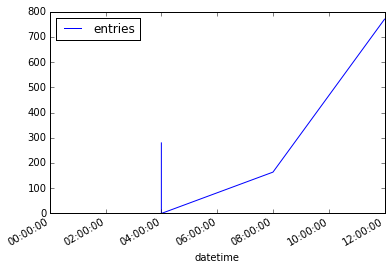

In [51]:
%matplotlib inline
mta.df[(mta.df.scp == '00-00-01') & (mta.df.station == '1 AVE')].head().plot(x='datetime', y='entries')

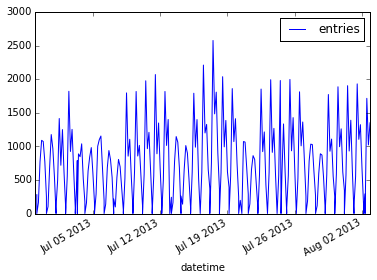

In [52]:
mta.df[(mta.df.scp == '00-00-01') & (mta.df.station == '1 AVE')].plot(x='datetime', y='entries')

In [53]:
test = mta.df[['datetime', 'entries', 'exits', 'station', 'date']]#.plot()#(x='datetime', y='entries')

In [54]:
test.head()

datetime  entries  exits station       date
168654 2013-06-29 00:00:00      NaN    NaN   1 AVE 2013-06-29
168655 2013-06-29 04:00:00      188    342   1 AVE 2013-06-29
168656 2013-06-29 04:00:00        0      0   1 AVE 2013-06-29
168657 2013-06-29 08:00:00      104    318   1 AVE 2013-06-29
168658 2013-06-29 12:00:00      564    664   1 AVE 2013-06-29

## Convert data

We need monthly data, so split by date and get into dfs for entries and exits

In [55]:
df_by_date = {
    'entries': {},
    'exits': {},
}

for (i_grouping, ((date, station), data)) in enumerate(test.groupby(['date', 'station'])):
#     print(i_grouping, _datetime, data.entries.sum())
    
    if station not in df_by_date['entries']:
        df_by_date['entries'][station] = {}
    if station not in df_by_date['exits']:
        df_by_date['exits'][station] = {}
    
    df_by_date['entries'][station][date] = data.entries.sum()
    df_by_date['exits'][station][date] = data.exits.sum()

df_by_date['entries'] = pd.DataFrame(df_by_date['entries'])
df_by_date['exits'] = pd.DataFrame(df_by_date['exits'])

df_by_date['entries'].head()

1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-06-29  15524   21893          13473    1402    7076             8769   
2013-06-30  18325   20028          12231    1075    6846             8755   
2013-07-01  20750   30153          17775    2320    9360            12233   
2013-07-02  21785   32221          18537    2404   11016            13158   
2013-07-03  22515   32573          18910    2440   11213            13468   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-06-29        5589    9177   21882             6651     ...       
2013-06-30        6205    8054   22183             6655     ...       
2013-07-01        7499   12359   29353            14116     ...       
2013-07-02        7999   12842   30890            15667     ...       
2013-07-03        8495   12472   31478            14785     ...       

            WESTCHESTER SQ  WHITEHALL ST  WHITLOCK AVE  WILSON AVE  \
2013-06-29            2959         10078           971        2446   
2013-06-30            2600         10708           923        2383   
2013-07-01            5697         13929          1492        3433   
2013-07-02            6109         15205          1558        3545   
2013-07-03            6021         12824          1586        3479   

            WINTHROP ST  WOODHAVEN BLVD  WOODLAWN ROAD  WORLD TRADE CTR  \
2013-06-29         3089           16515           4604             6237   
2013-06-30         2784           14445           4756             6163   
2013-07-01         5452           23480           7606            12123   
2013-07-02         7081           25707           7886            13551   
2013-07-03         7172           26416           8017            12843   

            YORK ST  ZEREGA AVE  
2013-06-29     4083        1251  
2013-06-30     4213        1188  
2013-07-01     7623        2483  
2013-07-02     8548        2575  
2013-07-03     8101        2521  

[5 rows x 382 columns]

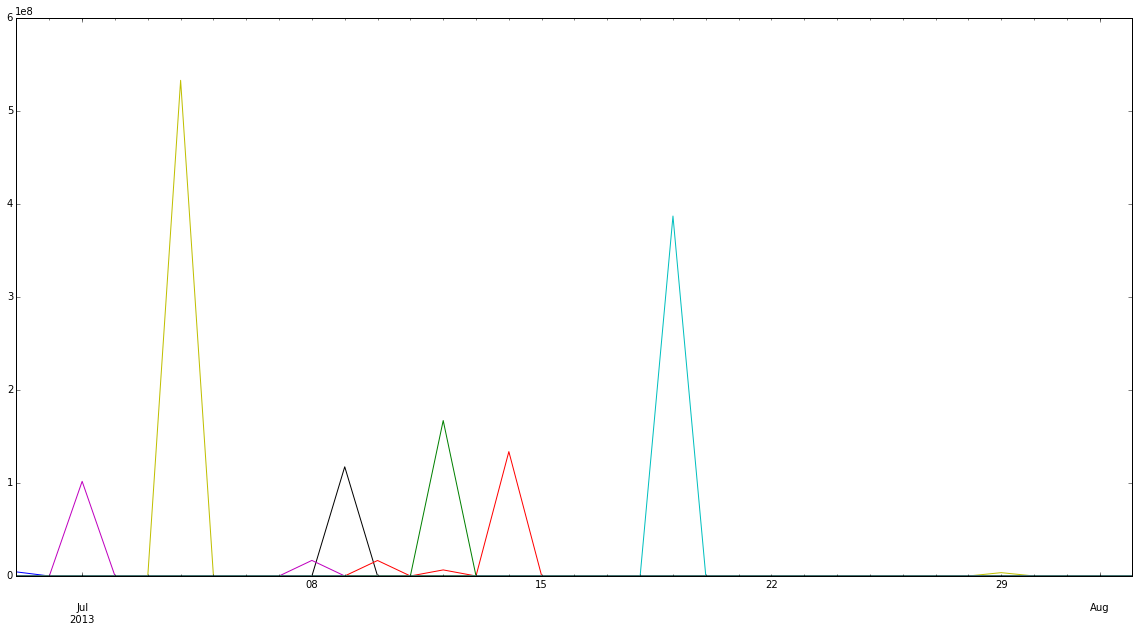

In [56]:
df_by_date['entries'].plot( figsize=(20,10), legend=False)

OK try with subset of stations...?

In [57]:
df_by_date['entries'].columns.tolist()
quarter_cols = len(df_by_date['entries'].columns.tolist()) / 4

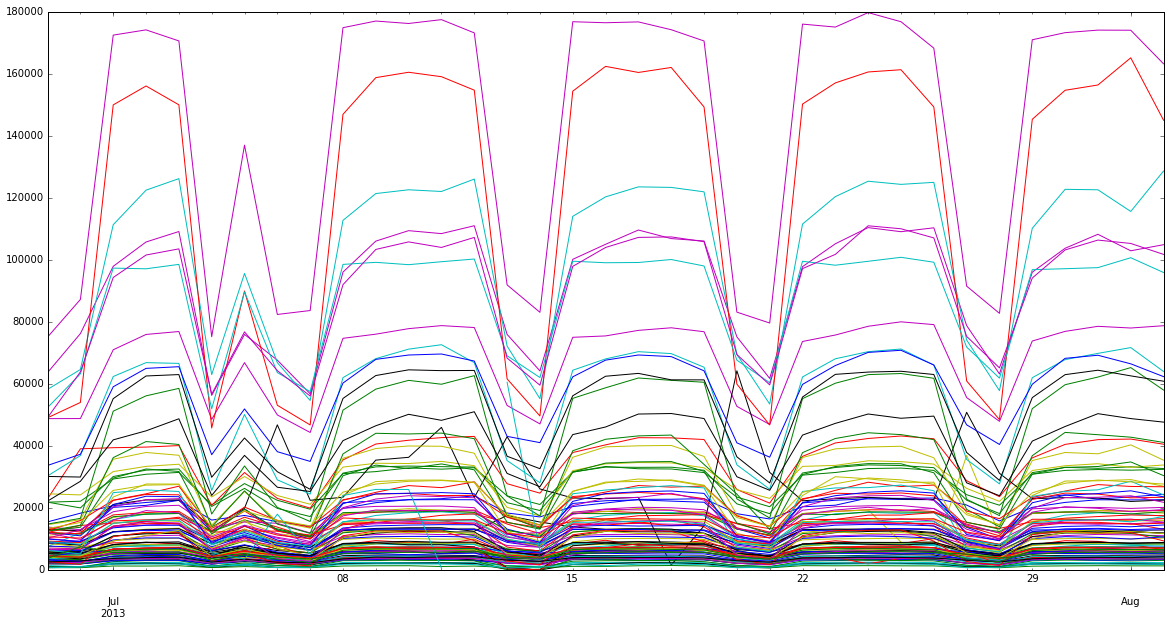

In [58]:
df_by_date['entries'][df_by_date['entries'].columns.tolist()[:quarter_cols]].plot( figsize=(20,10), legend=False)

# Interesting things

Pretty cool. we can see week day commuting.

Look we found July 4th!, looks like less people tend to use the subway then. Also notice the black and yellow lines (towards bottom) which follow a different trend than the others - more traffic back on the weekends. I bet these are stations like Cony Island or other vacation like destinations.

Now on to trying to find messed up ones...

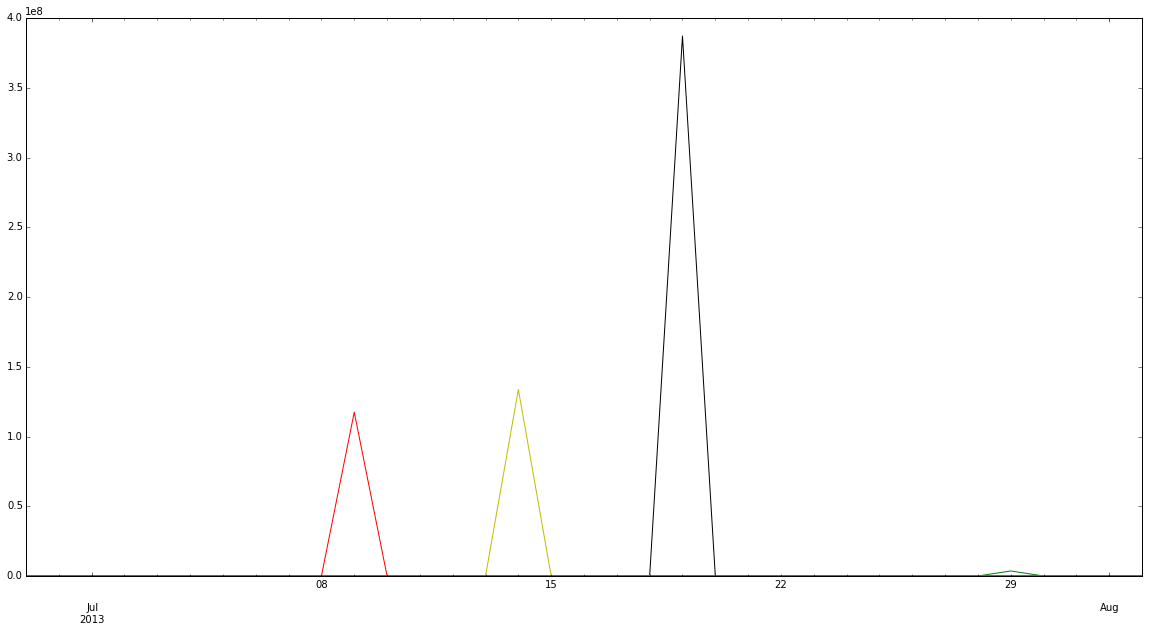

In [60]:
df_by_date['entries'][df_by_date['entries'].columns.tolist()[quarter_cols: quarter_cols * 2]].plot( figsize=(20,10), legend=False)

In [63]:
screwed_up_entries = df_by_date['entries'].sum()
screwed_up_entries.sort()

In [65]:
screwed_up_entries_normalized = screwed_up_entries / 1e8 # normalize by key in chart
screwed_up_entries_normalized.sort(ascending=False)
screwed_up_entries_normalized[0:11]

DYRE AVE           5.331245
7 AVE              3.873054
INWOOD-207 ST      1.674412
77 ST              1.348929
FOREST HILLS-71    1.192830
BEACH 98 ST        1.174604
MARCY AVE          0.235312
34 ST-PENN STA     0.050571
MORGAN AVE         0.046240
ATLANTIC AVE       0.044216
42 ST-GRD CNTRL    0.042376
dtype: float64

In [67]:
bad_stations_for_entries = screwed_up_entries_normalized[0:11]  # 11 chosen via trial and error
bad_stations_for_entries

DYRE AVE           5.331245
7 AVE              3.873054
INWOOD-207 ST      1.674412
77 ST              1.348929
FOREST HILLS-71    1.192830
BEACH 98 ST        1.174604
MARCY AVE          0.235312
34 ST-PENN STA     0.050571
MORGAN AVE         0.046240
ATLANTIC AVE       0.044216
42 ST-GRD CNTRL    0.042376
dtype: float64

In [74]:
entry_stations_to_fix = bad_stations_for_entries.index.values.tolist()
bad_stations_for_entries.index.values.tolist()

['DYRE AVE',
 '7 AVE',
 'INWOOD-207 ST',
 '77 ST',
 'FOREST HILLS-71',
 'BEACH 98 ST',
 'MARCY AVE',
 '34 ST-PENN STA',
 'MORGAN AVE',
 'ATLANTIC AVE',
 '42 ST-GRD CNTRL']

## Found You

Now I need to fix the mta dataset, we know the relative date range and the stations.

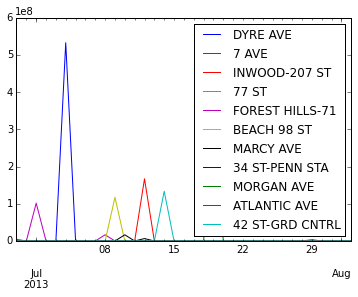

In [75]:
df_by_date['entries'][bad_stations_for_entries.index.values.tolist()].plot()

# Fix data

## Fix Entries

In [77]:
df_by_date['entries'][bad_stations_for_entries.index.values.tolist()]

DYRE AVE      7 AVE  INWOOD-207 ST      77 ST  FOREST HILLS-71  \
2013-06-29       2081       4673           5504      19991            14346   
2013-06-30       1597       4351           4824      18292            13372   
2013-07-01       4502       8186           8038      38385        101782237   
2013-07-02       4902       9028           8509      41805            27511   
2013-07-03       4798       8854           8109      40023            27795   
2013-07-04  532989539       4206           5112      17335            12915   
2013-07-05       3609       6049           6619      26950            20750   
2013-07-06       2158       4351           5161      18870            13726   
2013-07-07       1560       3897           4242      15037            11160   
2013-07-08       4839       8433           8237      37808         16757110   
2013-07-09       4990       9005           8627      42015            27855   
2013-07-10       5067       8908           9147      41212            28048   
2013-07-11       4988       9302           9126      42746            27944   
2013-07-12       4754       9085      167167057      40861            25637   
2013-07-13       2098       4957          15675      23328            15382   
2013-07-14       1573       4198          13505  133734975            12613   
2013-07-15       4809       8648           9687      39131            27061   
2013-07-16       5060       8872           8679      44086            26753   
2013-07-17       4988       9043           9191      41597            27986   
2013-07-18       4930       9036           9096      41678            27334   
2013-07-19       4727  387057271           8571      39491            25626   
2013-07-20       2158       4605           5727      21686            14745   
2013-07-21       1633       3578           4779      17360            12405   
2013-07-22       4858       8289           8299      38048            26638   
2013-07-23       5038       8728           8446      41931            27569   
2013-07-24       5023       8461           8990      42698            28470   
2013-07-25       4908       8785           9332      42459            28137   
2013-07-26       4786       8797           8867      40150            26759   
2013-07-27       2316       5106           6240      22878            15567   
2013-07-28       1579       3890           4595      17237            12194   
2013-07-29       4859       8450           8492      38236            26710   
2013-07-30       5104       9181           8889      41442            28162   
2013-07-31       4965       9263           8792      42114            28131   
2013-08-01       4845       9005           8349      42385            27782   
2013-08-02       4846       8859           8707      38662            26573   

            BEACH 98 ST  MARCY AVE  34 ST-PENN STA  MORGAN AVE  ATLANTIC AVE  \
2013-06-29          428       5448           75145     4395363         15460   
2013-06-30          344       5663           87280        6305         20632   
2013-07-01          314      10425          172546        6571         27309   
2013-07-02          308      11238          174234        6614         27498   
2013-07-03          362      11352          170676        6827         27755   
2013-07-04          877       6407           75253        4727         14549   
2013-07-05         1049       9313          137051        7101         22726   
2013-07-06          983       5721           82433        5569         16688   
2013-07-07         1061       4927           83699        4916         15319   
2013-07-08          553      10405          174942        6541         26900   
2013-07-09    117440971      10957          177083        6879         27660   
2013-07-10          376   16681609          176296        7095         26904   
2013-07-11          370      11450          177536        7209         27038   
2013-07-12          411    6546419          1732

so the bad dates to fix are:

|station | date|
|--|--|
|DYRE AVE | 2013-07-04
|7 AVE|2013-07-19
|INWOOD-207 ST|2013-07-12
|77 ST|2013-07-14
|FOREST HILLS-71|2013-07-08
|BEACH 98 ST|2013-07-09
| etc| etc|
(worst offenders)


In [86]:
fixed_entries = df_by_date['entries']
for station in fixed_entries[entry_stations_to_fix]:
    print(station, fixed_entries[station].max(), fixed_entries[station].idxmax(), fixed_entries[station].mean())
    
    fixed_entries.xs(fixed_entries[station].idxmax())[station] = 0
    # set to mean?
    fixed_entries.xs(fixed_entries[station].idxmax())[station] = fixed_entries[station].mean()
fixed_entries

('DYRE AVE', 4988.0, Timestamp('2013-07-17 00:00:00'), 3137.4371558517282)
('7 AVE', 9005.0, Timestamp('2013-07-09 00:00:00'), 5794.4523275301954)
('INWOOD-207 ST', 9096.0, Timestamp('2013-07-18 00:00:00'), 6242.2270440649727)
('77 ST', 41931.0, Timestamp('2013-07-23 00:00:00'), 27043.723631820078)
('FOREST HILLS-71', 27944.0, Timestamp('2013-07-11 00:00:00'), 18083.533011911702)
('BEACH 98 ST', 689.0, Timestamp('2013-07-16 00:00:00'), 396.83750570595583)
('MARCY AVE', 11289.0, Timestamp('2013-08-01 00:00:00'), 7384.3716298209083)
('34 ST-PENN STA', 176095.0, Timestamp('2013-07-22 00:00:00'), 114500.77767330279)
('MORGAN AVE', 7095.0, Timestamp('2013-07-10 00:00:00'), 5473.1579315285298)
('ATLANTIC AVE', 27785.0, Timestamp('2013-07-18 00:00:00'), 19481.98981757601)
('42 ST-GRD CNTRL', 158829.0, Timestamp('2013-07-09 00:00:00'), 92808.419878384011)


1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-06-29  15524   21893          13473    1402    7076             8769   
2013-06-30  18325   20028          12231    1075    6846             8755   
2013-07-01  20750   30153          17775    2320    9360            12233   
2013-07-02  21785   32221          18537    2404   11016            13158   
2013-07-03  22515   32573          18910    2440   11213            13468   
2013-07-04  16106   20503          12407    1316    6795             8477   
2013-07-05  17598   26329          17022    1971    9735            10436   
2013-07-06  15597   19875          13824    1397    7662             8235   
2013-07-07  14104   17237          10512    1088    6539             7466   
2013-07-08  19858   31256          17960    2398   10856            12210   
2013-07-09  21723   33269          18577    2448   11422            13268   
2013-07-10  22702   33527          19268    2371   11672            13370   
2013-07-11  23002   33342          19241    2439   11421            13437   
2013-07-12  23917   33207          19332    2341   11408            13422   
2013-07-13  18381   21720          14826    1440    7894             9545   
2013-07-14  17124   19193          11753    1158    7353             8054   
2013-07-15  20462   31600          18223    2379   11054            12259   
2013-07-16  21609   33189          18952    2440   11452            13004   
2013-07-17  22785   33115          18529    2474   11508            13409   
2013-07-18  22823   33157          18310    2479   11423            13041   
2013-07-19  23023   32176          18745    2350   11110            12873   
2013-07-20  18167   21343          14907    1445    7979             9200   
2013-07-21  16460   18174          12202     990    6562             8060   
2013-07-22  20383   31291          18193    2378   10558            12107   
2013-07-23  20900   33075          18905    2488   11047            13096   
2013-07-24  23235   33909          19420    2514   11320            13258   
2013-07-25  23103   33694          19393    2517   11405            13309   
2013-07-26  23219   33007          18867    2380   11246            13180   
2013-07-27  20958   22512          14811    1446    8101             9583   
2013-07-28  15830   18209          11878    1085    6508             8357   
2013-07-29  20208   31409          18226    2428   10700            11987   
2013-07-30  21805   33127          18641    2397   11094            12753   
2013-07-31  22651   32796          19130    2345   11481            12721   
2013-08-01  22618   33284          18951    2430   11323            12669   
2013-08-02  22664   32726          19222    2383   11058            12793   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-06-29        5589    9177   21882             6651     ...       
2013-06-30        6205    8054   22183             6655     ...       
2013-07-01        7499   12359   29353            14116     ...       
2013-07-02        7999   12842   30890            15667     ...       
2013-07-03        8495   12472   31478            14785     ...       
2013-07-04        6097    8546   20997             6380     ...       
2013-07-05        7928   11283   27878            10367     ...       
2013-07-06        6266    8720   22484             6660     ...       
2013-07-07        5474    7176   19616             5545     ...       
2013-07-08        8191   12906   31069            13218     ...       
2013-07-09        8514   13128   31739            15937     ...       
2013-07-10        8843   13308   32939            15924     ...       
2013-07-11        8715   13108   32530            15877     ...       
2013-07-12        8730   13081   32992            14703     ...       
2013-07-13        6669    9669   23916             7380     ...       
2013-07-14        6232    7858   21134             6129     ...       
2013-07-15        8661   13087  

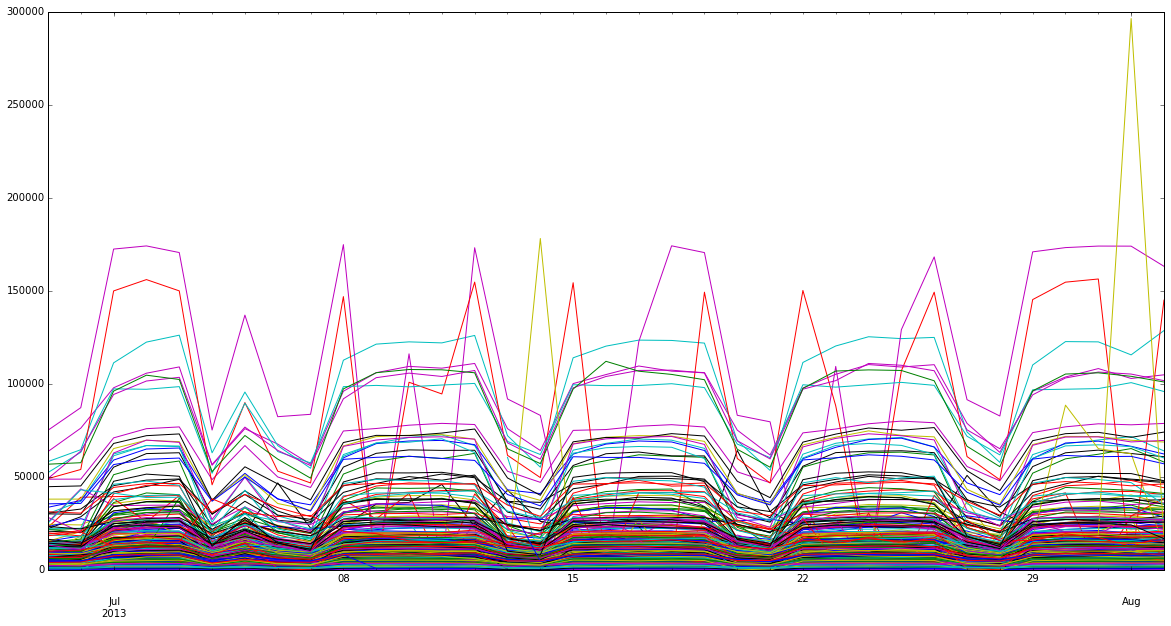

In [87]:
fixed_entries.plot( figsize=(20,10), legend=False)

A few more to fix...

In [91]:
fixed_entries.max().max()

296483.0

In [92]:
fixed_entries.max().idxmax()

'PAVONIA/NEWPORT'

In [93]:
fixed_entries['PAVONIA/NEWPORT']

2013-06-29      9304
2013-06-30      9028
2013-07-01     19057
2013-07-02     19645
2013-07-03     19654
2013-07-04      8316
2013-07-05     16607
2013-07-06      9050
2013-07-07      6660
2013-07-08     19074
2013-07-09     19892
2013-07-10     19979
2013-07-11     19695
2013-07-12     18582
2013-07-13      9671
2013-07-14      7988
2013-07-15     19230
2013-07-16     19834
2013-07-17     19893
2013-07-18     20047
2013-07-19     19773
2013-07-20      9598
2013-07-21      7658
2013-07-22     19148
2013-07-23     19853
2013-07-24     20302
2013-07-25     19904
2013-07-26     19085
2013-07-27      9768
2013-07-28      7224
2013-07-29     18836
2013-07-30     19455
2013-07-31     18903
2013-08-01    296483
2013-08-02     17477
Name: PAVONIA/NEWPORT, dtype: float64

## Well this is our august 1st data....

We did the August 1st analysis assuming it didn't break any trend, may have to go back now...

In [94]:
fixed_entries.xs(datetime(2013, 8, 1))['PAVONIA/NEWPORT'] = 0 # should not matter for July analysis, just for printing a graph

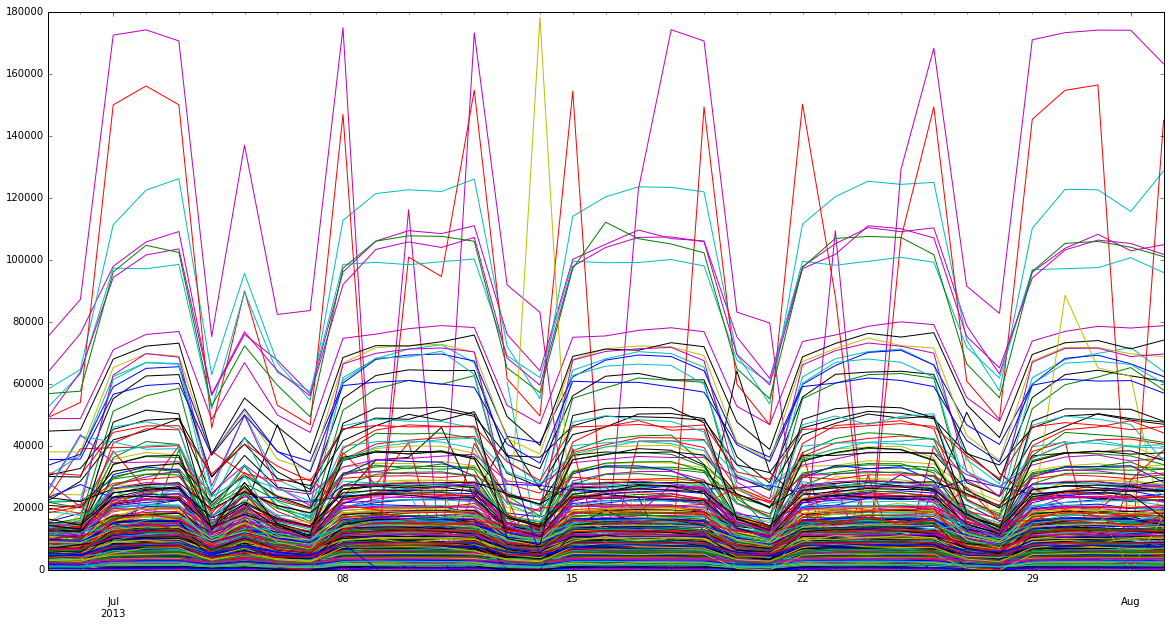

In [95]:
fixed_entries.plot( figsize=(20,10), legend=False)

In [102]:
july_entries = fixed_entries[datetime(2013, 7, 1): datetime(2013, 7, 31)]
july_entries.index

DatetimeIndex(['2013-07-01', '2013-07-02', '2013-07-03', '2013-07-04',
               '2013-07-05', '2013-07-06', '2013-07-07', '2013-07-08',
               '2013-07-09', '2013-07-10', '2013-07-11', '2013-07-12',
               '2013-07-13', '2013-07-14', '2013-07-15', '2013-07-16',
               '2013-07-17', '2013-07-18', '2013-07-19', '2013-07-20',
               '2013-07-21', '2013-07-22', '2013-07-23', '2013-07-24',
               '2013-07-25', '2013-07-26', '2013-07-27', '2013-07-28',
               '2013-07-29', '2013-07-30', '2013-07-31'],
              dtype='datetime64[ns]', freq=None, tz=None)

In [103]:
july_entries.head()

1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-07-01  20750   30153          17775    2320    9360            12233   
2013-07-02  21785   32221          18537    2404   11016            13158   
2013-07-03  22515   32573          18910    2440   11213            13468   
2013-07-04  16106   20503          12407    1316    6795             8477   
2013-07-05  17598   26329          17022    1971    9735            10436   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-07-01        7499   12359   29353            14116     ...       
2013-07-02        7999   12842   30890            15667     ...       
2013-07-03        8495   12472   31478            14785     ...       
2013-07-04        6097    8546   20997             6380     ...       
2013-07-05        7928   11283   27878            10367     ...       

            WESTCHESTER SQ  WHITEHALL ST  WHITLOCK AVE  WILSON AVE  \
2013-07-01            5697         13929          1492        3433   
2013-07-02            6109         15205          1558        3545   
2013-07-03            6021         12824          1586        3479   
2013-07-04            2713          8092          1062        2529   
2013-07-05            4790         14461          1352        3384   

            WINTHROP ST  WOODHAVEN BLVD  WOODLAWN ROAD  WORLD TRADE CTR  \
2013-07-01         5452           23480           7606            12123   
2013-07-02         7081           25707           7886            13551   
2013-07-03         7172           26416           8017            12843   
2013-07-04         3167           16794           4839             6133   
2013-07-05         5715           21937           7489             9692   

            YORK ST  ZEREGA AVE  
2013-07-01     7623        2483  
2013-07-02     8548        2575  
2013-07-03     8101        2521  
2013-07-04     3693        1323  
2013-07-05     5709        2171  

[5 rows x 382 columns]

## Fix Exits

assuming similar errors for exits.

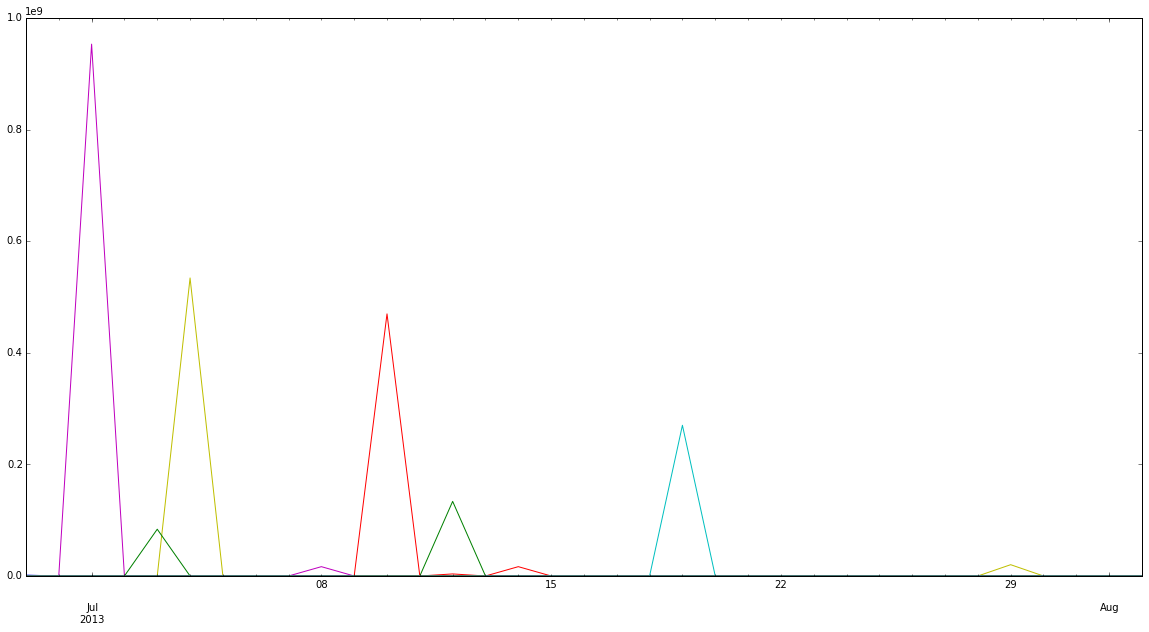

In [104]:
df_by_date['exits'].plot( figsize=(20,10), legend=False)

In [128]:
july_exits = df_by_date['exits'][datetime(2013, 7, 1): datetime(2013, 7, 31)]

july_exits.head()

1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-07-01  21632   20991          12876    1672    8442             6193   
2013-07-02  22092   21765          13549    1844    9222             6822   
2013-07-03  23638   21390          14120    1875    9462             6583   
2013-07-04  14587   12695          11350    1186    5972             3806   
2013-07-05  22166   18479          12134    1548    7858             5479   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-07-01        4614    8974   17145             6863     ...       
2013-07-02        4591    9787   18128             7416     ...       
2013-07-03        5637    9985   18234             6954     ...       
2013-07-04        4330    7871   11698             2581     ...       
2013-07-05        5502    8597   17121             5187     ...       

            WESTCHESTER SQ  WHITEHALL ST  WHITLOCK AVE  WILSON AVE  \
2013-07-01            5301         11724          1412        2942   
2013-07-02            5625         12739          1515        3055   
2013-07-03            5683         11143          1474        3240   
2013-07-04            3051          7744           941        2581   
2013-07-05            4753         10788          1304        3034   

            WINTHROP ST  WOODHAVEN BLVD  WOODLAWN ROAD  WORLD TRADE CTR  \
2013-07-01         1435           15620           1741             6424   
2013-07-02         1571           16747           1884             6951   
2013-07-03         1620           18059           1814             6836   
2013-07-04          761           12081           1575             4226   
2013-07-05         1213           16152           1597             6415   

            YORK ST  ZEREGA AVE  
2013-07-01     6734        1697  
2013-07-02     7293        1723  
2013-07-03     7054        1726  
2013-07-04     3869        1015  
2013-07-05     5090        1511  

[5 rows x 382 columns]

In [129]:
max_exits = july_exits.max()
max_exits.sort(ascending=False)
max_exits[0:15]

FOREST HILLS-71    953165446
DYRE AVE           534128238
MARCY AVE          469749073
7 AVE              270122256
INWOOD-207 ST      133746335
ATLANTIC AVE        20262343
77 ST               16734397
EXCHANGE PLACE        341138
34 ST-PENN STA        165068
BEACH 90 ST           164206
42 ST-GRD CNTRL       152746
34 ST-HERALD SQ       120950
42 ST-TIMES SQ        108401
14 ST-UNION SQ        101576
86 ST                  92117
dtype: float64

In [130]:
max_exits_normalized = max_exits / 1e9
max_exits_normalized.sort(ascending=False)
max_exits_normalized[0:15]

FOREST HILLS-71    0.953165
DYRE AVE           0.534128
MARCY AVE          0.469749
7 AVE              0.270122
INWOOD-207 ST      0.133746
ATLANTIC AVE       0.020262
77 ST              0.016734
EXCHANGE PLACE     0.000341
34 ST-PENN STA     0.000165
BEACH 90 ST        0.000164
42 ST-GRD CNTRL    0.000153
34 ST-HERALD SQ    0.000121
42 ST-TIMES SQ     0.000108
14 ST-UNION SQ     0.000102
86 ST              0.000092
dtype: float64

In [131]:
max_exits[0:8]

FOREST HILLS-71    953165446
DYRE AVE           534128238
MARCY AVE          469749073
7 AVE              270122256
INWOOD-207 ST      133746335
ATLANTIC AVE        20262343
77 ST               16734397
EXCHANGE PLACE        341138
dtype: float64

In [132]:
exit_stations_to_fix = max_exits[0:8].index.values.tolist()
exit_stations_to_fix

['FOREST HILLS-71',
 'DYRE AVE',
 'MARCY AVE',
 '7 AVE',
 'INWOOD-207 ST',
 'ATLANTIC AVE',
 '77 ST',
 'EXCHANGE PLACE']

We need to fix 0:8

In [133]:
for station in july_exits[exit_stations_to_fix]:
    print(station, july_exits[station].max(), july_exits[station].idxmax(), july_exits[station].mean())
    
    july_exits.xs(july_exits[station].idxmax())[station] = 0
    # set to mean?
    july_exits.xs(july_exits[station].idxmax())[station] = july_exits[station].mean()
july_exits

('FOREST HILLS-71', 953165446.0, Timestamp('2013-07-01 00:00:00'), 31295824.036671363)
('DYRE AVE', 534128238.0, Timestamp('2013-07-04 00:00:00'), 17233653.730159745)
('MARCY AVE', 469749073.0, Timestamp('2013-07-10 00:00:00'), 15278417.256069878)
('7 AVE', 270122256.0, Timestamp('2013-07-19 00:00:00'), 8720399.1640535258)
('INWOOD-207 ST', 133746335.0, Timestamp('2013-07-12 00:00:00'), 4318940.5615556426)
('ATLANTIC AVE', 20262343.0, Timestamp('2013-07-29 00:00:00'), 672849.87352653453)
('77 ST', 16734397.0, Timestamp('2013-07-14 00:00:00'), 569126.11983610527)
('EXCHANGE PLACE', 341138.0, Timestamp('2013-07-30 00:00:00'), 23618.548387096773)


1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-07-01  21632   20991          12876    1672    8442             6193   
2013-07-02  22092   21765          13549    1844    9222             6822   
2013-07-03  23638   21390          14120    1875    9462             6583   
2013-07-04  14587   12695          11350    1186    5972             3806   
2013-07-05  22166   18479          12134    1548    7858             5479   
2013-07-06  16604   13614           6364    1286    6930             3985   
2013-07-07  15789   12271           3711    1102    6130             3916   
2013-07-08  21132   20560          11137    1694    9103             6366   
2013-07-09  22617   23012          14630    1942    9691             6585   
2013-07-10  23368   22215          14410    1921    9508             6660   
2013-07-11  23644   23278          14380    1951    9850             6645   
2013-07-12  25527   23293          14264    1821    9542             6532   
2013-07-13  20268   15174          11854    1329    7524             3945   
2013-07-14  18286   14321          10522    1034    7103             3618   
2013-07-15  21560   23089          13494    1678    9466             5929   
2013-07-16  22882   22667          14342    1906    9651             6623   
2013-07-17  22955   24124          14872    1983    9707             6541   
2013-07-18  23289   23904          14206    1899    9874             6769   
2013-07-19  24340   23100          14054    1759    9551             6181   
2013-07-20  19487   15721          12927    1255    7191             4376   
2013-07-21  17973   13493          10355    1086    6188             4192   
2013-07-22  22366   21841          12108    1753    8968             6221   
2013-07-23  22460   23502          13139    1984    9099             6443   
2013-07-24  22736   24463          13570    2012    9754             6633   
2013-07-25  23841   23411          14348    1970    9633             6637   
2013-07-26  23807   22838          14192    1873    9769             6273   
2013-07-27  20349   16352          12431    1354    7153             4559   
2013-07-28  18872   14139          10417    1094    6025             4355   
2013-07-29  21140   21766          12951    1817    8972             6113   
2013-07-30  22453   23169          14175    1819    9501             6472   
2013-07-31  22852   22375          14861    1904    9663             6060   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-07-01        4614    8974   17145             6863     ...       
2013-07-02        4591    9787   18128             7416     ...       
2013-07-03        5637    9985   18234             6954     ...       
2013-07-04        4330    7871   11698             2581     ...       
2013-07-05        5502    8597   17121             5187     ...       
2013-07-06        4670    7297   13063             2996     ...       
2013-07-07        4394    6333   12098             2963     ...       
2013-07-08        5480    8938   17457             7028     ...       
2013-07-09        5445   10034   18855             7641     ...       
2013-07-10        5626   10013   19094             7591     ...       
2013-07-11        5059   10099   18726             7319     ...       
2013-07-12        4834   10297   19158             6857     ...       
2013-07-13        4365    8147   14840             2916     ...       
2013-07-14        5366    7333   13585             2712     ...       
2013-07-15        5571    8960   18381             6916     ...       
2013-07-16        5909    9780   19139             8125     ...       
2013-07-17        5872   10063   19022             7082     ...       
2013-07-18        6042   10146   18771             7892     ...       
2013-07-19        5841    9947   18345             6335     ...       
2013-07-20        4610    8370   13897             3198     ...       
2013-07-21        4358    7562   12803             3163 

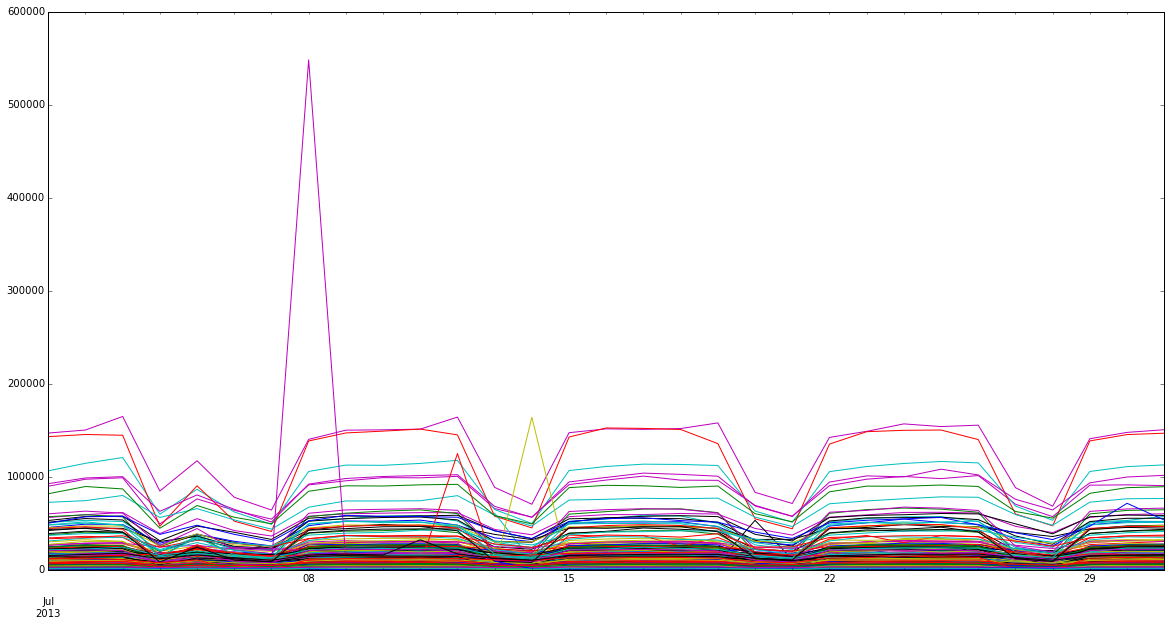

In [134]:
july_exits.plot( figsize=(20,10), legend=False)

## one more to fix

In [136]:
july_exits.max().max()

548551.58505845966

In [138]:
july_exits.max().idxmax()

'FOREST HILLS-71'

In [139]:
july_exits['FOREST HILLS-71']

2013-07-01         0.000000
2013-07-02     11075.000000
2013-07-03     16983.136812
2013-07-04      5023.000000
2013-07-05      8754.000000
2013-07-06      5695.000000
2013-07-07      4749.000000
2013-07-08    548551.585058
2013-07-09     11312.000000
2013-07-10     11445.000000
2013-07-11     11592.000000
2013-07-12     10516.000000
2013-07-13      6292.000000
2013-07-14      5491.000000
2013-07-15     10840.000000
2013-07-16     10981.000000
2013-07-17     11101.000000
2013-07-18     11034.000000
2013-07-19     10548.000000
2013-07-20      6270.000000
2013-07-21      5155.000000
2013-07-22     11176.000000
2013-07-23     10763.000000
2013-07-24     11406.000000
2013-07-25     11372.000000
2013-07-26     10316.000000
2013-07-27      6714.000000
2013-07-28      5323.000000
2013-07-29     10636.000000
2013-07-30     11456.000000
2013-07-31     11737.000000
Name: FOREST HILLS-71, dtype: float64

In [140]:
july_exits.xs(datetime(2013, 7, 8))['FOREST HILLS-71'] = 0

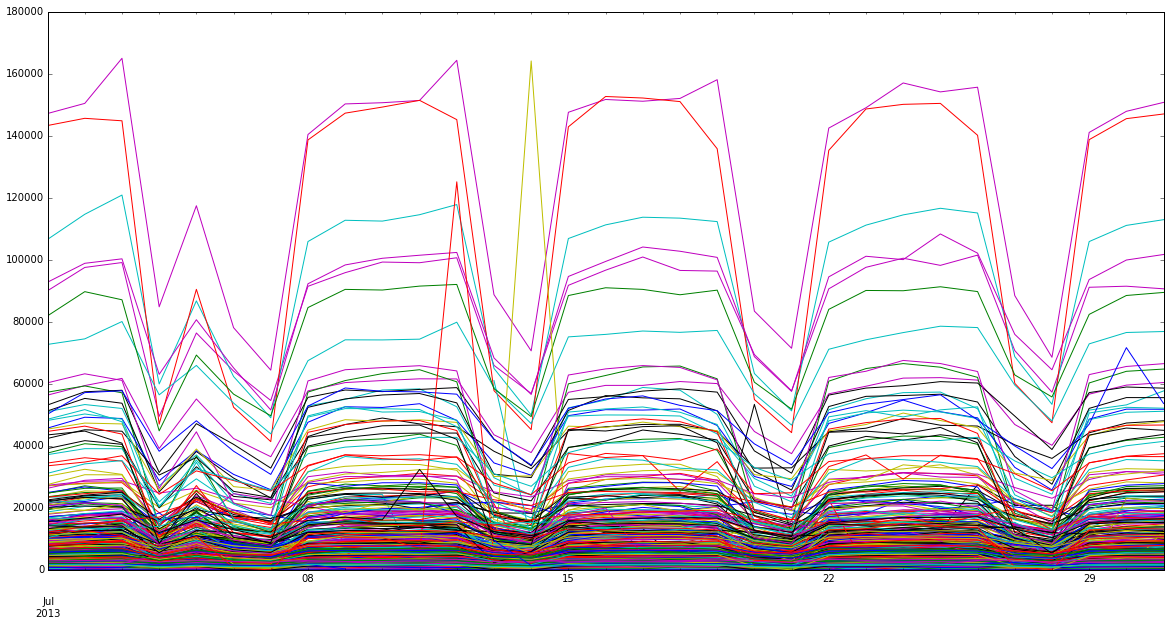

In [141]:
july_exits.plot( figsize=(20,10), legend=False)

# Prep July data, with 'Busy-ness'

In [142]:
july_busyness = july_exits + july_entries

In [146]:
july_exits.head()

1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-07-01  21632   20991          12876    1672    8442             6193   
2013-07-02  22092   21765          13549    1844    9222             6822   
2013-07-03  23638   21390          14120    1875    9462             6583   
2013-07-04  14587   12695          11350    1186    5972             3806   
2013-07-05  22166   18479          12134    1548    7858             5479   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-07-01        4614    8974   17145             6863     ...       
2013-07-02        4591    9787   18128             7416     ...       
2013-07-03        5637    9985   18234             6954     ...       
2013-07-04        4330    7871   11698             2581     ...       
2013-07-05        5502    8597   17121             5187     ...       

            WESTCHESTER SQ  WHITEHALL ST  WHITLOCK AVE  WILSON AVE  \
2013-07-01            5301         11724          1412        2942   
2013-07-02            5625         12739          1515        3055   
2013-07-03            5683         11143          1474        3240   
2013-07-04            3051          7744           941        2581   
2013-07-05            4753         10788          1304        3034   

            WINTHROP ST  WOODHAVEN BLVD  WOODLAWN ROAD  WORLD TRADE CTR  \
2013-07-01         1435           15620           1741             6424   
2013-07-02         1571           16747           1884             6951   
2013-07-03         1620           18059           1814             6836   
2013-07-04          761           12081           1575             4226   
2013-07-05         1213           16152           1597             6415   

            YORK ST  ZEREGA AVE  
2013-07-01     6734        1697  
2013-07-02     7293        1723  
2013-07-03     7054        1726  
2013-07-04     3869        1015  
2013-07-05     5090        1511  

[5 rows x 382 columns]

In [147]:
july_entries.head()

1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-07-01  20750   30153          17775    2320    9360            12233   
2013-07-02  21785   32221          18537    2404   11016            13158   
2013-07-03  22515   32573          18910    2440   11213            13468   
2013-07-04  16106   20503          12407    1316    6795             8477   
2013-07-05  17598   26329          17022    1971    9735            10436   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-07-01        7499   12359   29353            14116     ...       
2013-07-02        7999   12842   30890            15667     ...       
2013-07-03        8495   12472   31478            14785     ...       
2013-07-04        6097    8546   20997             6380     ...       
2013-07-05        7928   11283   27878            10367     ...       

            WESTCHESTER SQ  WHITEHALL ST  WHITLOCK AVE  WILSON AVE  \
2013-07-01            5697         13929          1492        3433   
2013-07-02            6109         15205          1558        3545   
2013-07-03            6021         12824          1586        3479   
2013-07-04            2713          8092          1062        2529   
2013-07-05            4790         14461          1352        3384   

            WINTHROP ST  WOODHAVEN BLVD  WOODLAWN ROAD  WORLD TRADE CTR  \
2013-07-01         5452           23480           7606            12123   
2013-07-02         7081           25707           7886            13551   
2013-07-03         7172           26416           8017            12843   
2013-07-04         3167           16794           4839             6133   
2013-07-05         5715           21937           7489             9692   

            YORK ST  ZEREGA AVE  
2013-07-01     7623        2483  
2013-07-02     8548        2575  
2013-07-03     8101        2521  
2013-07-04     3693        1323  
2013-07-05     5709        2171  

[5 rows x 382 columns]

In [148]:
july_busyness.head()

1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  \
2013-07-01  42382   51144          30651    3992   17802            18426   
2013-07-02  43877   53986          32086    4248   20238            19980   
2013-07-03  46153   53963          33030    4315   20675            20051   
2013-07-04  30693   33198          23757    2502   12767            12283   
2013-07-05  39764   44808          29156    3519   17593            15915   

            110 ST-CPN  111 ST  116 ST  116 ST-COLUMBIA     ...      \
2013-07-01       12113   21333   46498            20979     ...       
2013-07-02       12590   22629   49018            23083     ...       
2013-07-03       14132   22457   49712            21739     ...       
2013-07-04       10427   16417   32695             8961     ...       
2013-07-05       13430   19880   44999            15554     ...       

            WESTCHESTER SQ  WHITEHALL ST  WHITLOCK AVE  WILSON AVE  \
2013-07-01           10998         25653          2904        6375   
2013-07-02           11734         27944          3073        6600   
2013-07-03           11704         23967          3060        6719   
2013-07-04            5764         15836          2003        5110   
2013-07-05            9543         25249          2656        6418   

            WINTHROP ST  WOODHAVEN BLVD  WOODLAWN ROAD  WORLD TRADE CTR  \
2013-07-01         6887           39100           9347            18547   
2013-07-02         8652           42454           9770            20502   
2013-07-03         8792           44475           9831            19679   
2013-07-04         3928           28875           6414            10359   
2013-07-05         6928           38089           9086            16107   

            YORK ST  ZEREGA AVE  
2013-07-01    14357        4180  
2013-07-02    15841        4298  
2013-07-03    15155        4247  
2013-07-04     7562        2338  
2013-07-05    10799        3682  

[5 rows x 382 columns]

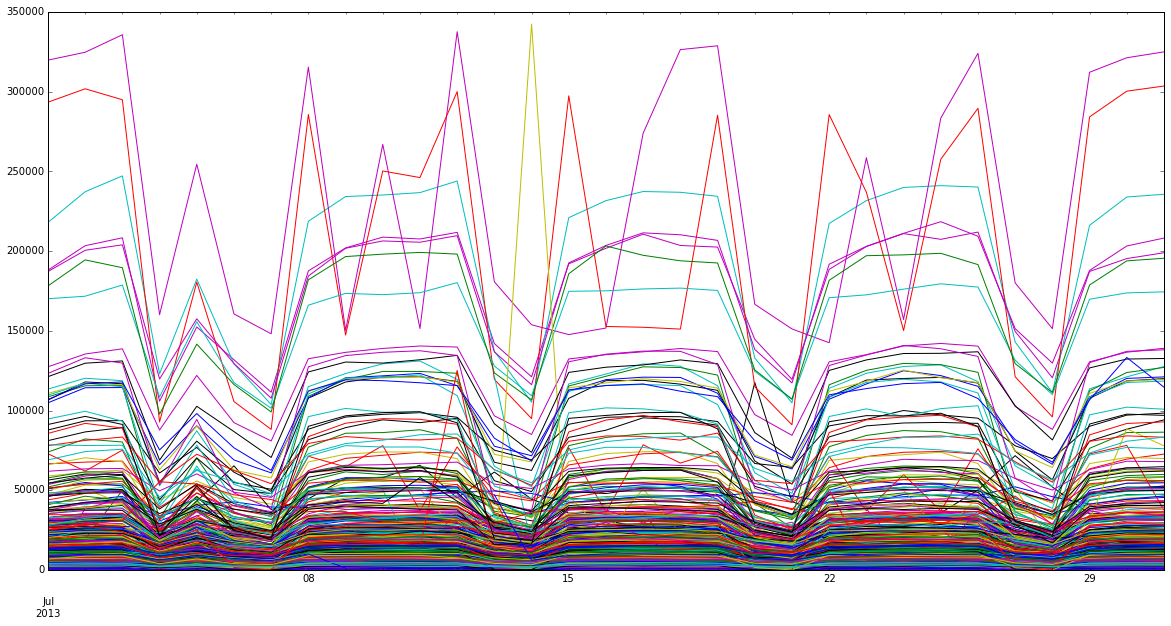

In [149]:
july_busyness.plot(figsize=(20,10), legend=False)

# Analysis

## 3. What were the busiest and least-busy stations in the system over all of July 2013?

In [150]:
max_stations = july_busyness.mean()
max_stations.sort(ascending=False)
max_stations.head()

34 ST-PENN STA     234276.829372
42 ST-GRD CNTRL    205542.165942
34 ST-HERALD SQ    198777.354839
42 ST-TIMES SQ     179415.419355
14 ST-UNION SQ     178422.741935
dtype: float64

In [151]:
max_stations.tail()

BEACH 44 ST       967.064516
TOMPKINSVILLE     568.903226
ORCHARD BEACH     549.322581
BROAD CHANNEL     256.935484
AQUEDUCT TRACK      8.645161
dtype: float64

## Analysis of 3

This is consistent with our previous analysis. The stations which have a lot of transfering stations and are located in central areas are the busiest

## 4. Which station had the highest average number of entries between midnight & 4am on Fridays in July 2013?

We will have to reconstruct this using the data above. Good thing is that we know the bad days of data

## Previous fixes


### Entries

|Station|day|
|--|--|
|PAVONIA/NEWPORT| 2013-08-01
|DYRE AVE|2013-07-17
|7 AVE| 2013-07-09
| INWOOD-207 ST| 2013-07-18
|77 ST| 2013-07-23
| FOREST HILLS-71|2013-07-11
|BEACH 98 ST|2013-07-16
| MARCY AVE | 2013-08-01
| 34 ST-PENN STA | 2013-07-22
| MORGAN AVE | 2013-07-10
| ATLANTIC AVE | 2013-07-18
| 42 ST-GRD CNTRL|2013-07-09


### Exits

|Station|day|
|--|--|
|FOREST HILLS-71| 2013-07-08  
|FOREST HILLS-71| 2013-07-01
|DYRE AVE | 2013-07-04
| MARCY AVE | 2013-07-10
|7 AVE|2013-07-19
|INWOOD-207 ST|2013-07-12
|ATLANTIC AVE|2013-07-29
|77 ST|2013-07-14
|EXCHANGE PLACE|2013-07-30


In [159]:
from datetime import timedelta

In [160]:
date_start = datetime(2013, 7, 1)
date_end = datetime(2013, 7, 31)

fridays_in_july = []

current_date = date_start

while current_date <= date_end:
    
    if current_date.strftime("%A") == 'Friday':
        print('Friday:', current_date)
        fridays_in_july.append(current_date)
#     print(current_date, current_date.day, current_date.strftime("%A"))
    current_date += timedelta(days=1)

('Friday:', datetime.datetime(2013, 7, 5, 0, 0))
('Friday:', datetime.datetime(2013, 7, 12, 0, 0))
('Friday:', datetime.datetime(2013, 7, 19, 0, 0))
('Friday:', datetime.datetime(2013, 7, 26, 0, 0))


In [161]:
fridays_in_july

[datetime.datetime(2013, 7, 5, 0, 0),
 datetime.datetime(2013, 7, 12, 0, 0),
 datetime.datetime(2013, 7, 19, 0, 0),
 datetime.datetime(2013, 7, 26, 0, 0)]

Lets see if any of those dates oversect with the ones we knew may have errors...

|date| fix|
|--|--|
|2013-07-12|INWOOD-207 ST
|2013-07-19| 7th Ave

Ok that's manageable. Let's see if it is even possible for these to be among the highest

In [177]:
inwood_data = mta.df[(mta.df.station == 'INWOOD-207 ST') & (mta.df.date == datetime(2013, 7,12))]

inwood_data[
    (inwood_data.datetime >= datetime(2013, 7, 12, 0, 0, 0)) & (inwood_data.datetime < datetime(2013, 7, 12, 4, 0, 0))
][['datetime', 'entries', 'exits']]

datetime  entries  exits
231391 2013-07-12 01:00:00       90    219
231433 2013-07-12 01:00:00       75    144
231475 2013-07-12 01:00:00      121    225
231517 2013-07-12 01:00:00        1      0
231559 2013-07-12 01:00:00        0      0
229290 2013-07-12 01:00:00        0      0
229332 2013-07-12 01:00:00        0      0
229374 2013-07-12 01:00:00       68    169
229416 2013-07-12 01:00:00       12     45
229458 2013-07-12 01:00:00       35     94
229726 2013-07-12 00:05:25        5      0
229727 2013-07-12 00:22:57        2      0
229728 2013-07-12 00:51:09        3      0
229729 2013-07-12 00:52:52        2      0
229730 2013-07-12 01:00:00        1      0

OK no need to fix any data there

In [178]:
seventh_ave = mta.df[(mta.df.station == '7th Ave') & (mta.df.date == datetime(2013, 7,12))]

seventh_ave[
    (seventh_ave.datetime >= datetime(2013, 7, 12, 0, 0, 0)) & (seventh_ave.datetime < datetime(2013, 7, 12, 4, 0, 0))
][['datetime', 'entries', 'exits']]

Empty DataFrame
Columns: [datetime, entries, exits]
Index: []

and no data is relevant there

In [299]:
fridays_in_july

[datetime.datetime(2013, 7, 5, 0, 0),
 datetime.datetime(2013, 7, 12, 0, 0),
 datetime.datetime(2013, 7, 19, 0, 0),
 datetime.datetime(2013, 7, 26, 0, 0)]

In [301]:
count = 0
for date in fridays_in_july:
    count += len(mta.df[mta.df.date == date])
data_for_days = mta.df[mta.df.date.isin(fridays_in_july)]
data_for_days.count().max() == count

True

In [303]:
data_for_days.date.unique()

array(['2013-07-04T20:00:00.000000000-0400',
       '2013-07-11T20:00:00.000000000-0400',
       '2013-07-18T20:00:00.000000000-0400',
       '2013-07-25T20:00:00.000000000-0400'], dtype='datetime64[ns]')

In [309]:
data_for_days['hour'] = data_for_days.datetime.apply(lambda x: x.hour)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [311]:
data_for_days[['hour', 'datetime']].head()

hour            datetime
168703     0 2013-07-05 00:00:00
168705     4 2013-07-05 04:00:00
168704     4 2013-07-05 04:00:00
168706     8 2013-07-05 08:00:00
168707    12 2013-07-05 12:00:00

In [312]:
fridays_morning_data = data_for_days[
    (data_for_days.hour >= 0) & (data_for_days.hour <= 4)
]
len(fridays_morning_data)

32982

In [322]:
friday_morning_busyness = {}

for (station, hour), data in fridays_morning_data.groupby(['station', 'hour']):
    
    if station not in friday_morning_busyness:
        friday_morning_busyness[station] = {}
        
    friday_morning_busyness[station][hour] = data.entries.sum() #+ data.exits.sum()
friday_morning_busyness = pd.DataFrame(friday_morning_busyness)
friday_morning_busyness

1 AVE  103 ST  103 ST-CORONA  104 ST  110 ST  110 ST-CATHEDRL  110 ST-CPN  \
0  16116     NaN           3684     479    4002              NaN        3106   
1    NaN    9173            NaN     NaN     NaN             4608         NaN   
2    NaN     NaN            NaN     NaN     NaN              NaN         NaN   
3    NaN     NaN            NaN     NaN     NaN              NaN         NaN   
4   4329     NaN           1733     161     769              NaN        1492   

   111 ST  116 ST  116 ST-COLUMBIA     ...      WESTCHESTER SQ  WHITEHALL ST  \
0    3126     NaN              NaN     ...                1847           NaN   
1     NaN    9899             3712     ...                 NaN          4424   
2     NaN     NaN              NaN     ...                 NaN           NaN   
3     NaN     NaN              NaN     ...                 NaN           NaN   
4     667     NaN              NaN     ...                 362           NaN   

   WHITLOCK AVE  WILSON AVE  WINTHROP ST  WOODHAVEN BLVD  WOODLAWN ROAD  \
0           520        1336          NaN            1709           2762   
1           NaN         NaN         1160            4214            NaN   
2           NaN         NaN          NaN             NaN            NaN   
3           NaN         NaN          NaN             NaN            NaN   
4           145         264          NaN             332            645   

   WORLD TRADE CTR  YORK ST  ZEREGA AVE  
0             5312      NaN         NaN  
1              NaN     4228         478  
2              NaN      NaN         NaN  
3              NaN      NaN         NaN  
4              711      NaN         NaN  

[5 rows x 382 columns]

Note, remember this data comes in once every ~4 hours, unless there is a maintenance event, so makes sense only 1-2 values per col

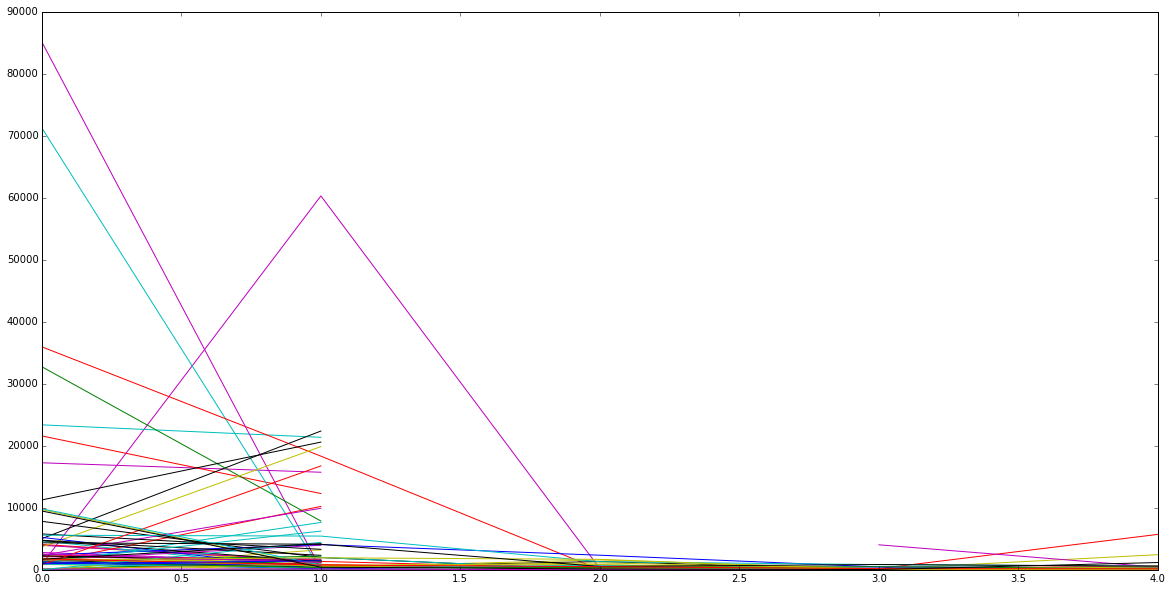

In [323]:
friday_morning_busyness.plot(legend=False, figsize=(20,10))

In [329]:
most_busy = friday_morning_busyness.sum() / len(fridays_in_july)
most_busy.sort(ascending=False)
most_busy.head()

42 ST-TIMES SQ     27236.75
34 ST-PENN STA     21425.00
34 ST-HERALD SQ    20684.50
42 ST-PA BUS TE    16124.25
14 ST-UNION SQ     15358.50
dtype: float64

Using the "highest avg", `42 ST-TIMES SQ` had the highest average number of entries between midnight & 4am on Fridays in July 2013

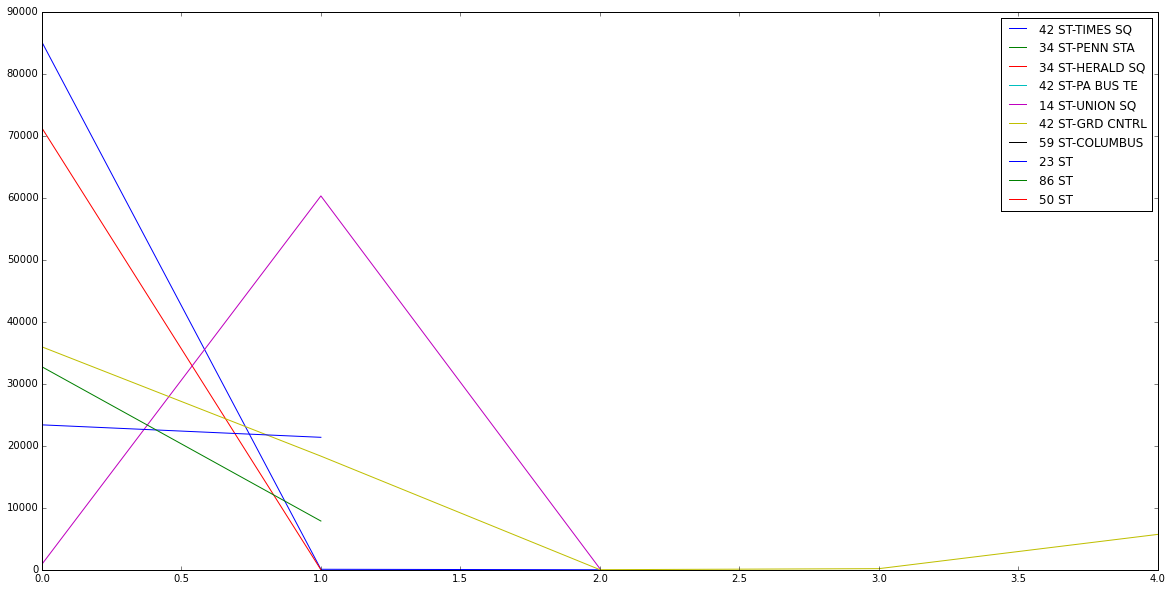

In [334]:
friday_morning_busyness[most_busy[0:10].index].plot(legend=True, figsize=(20,10))

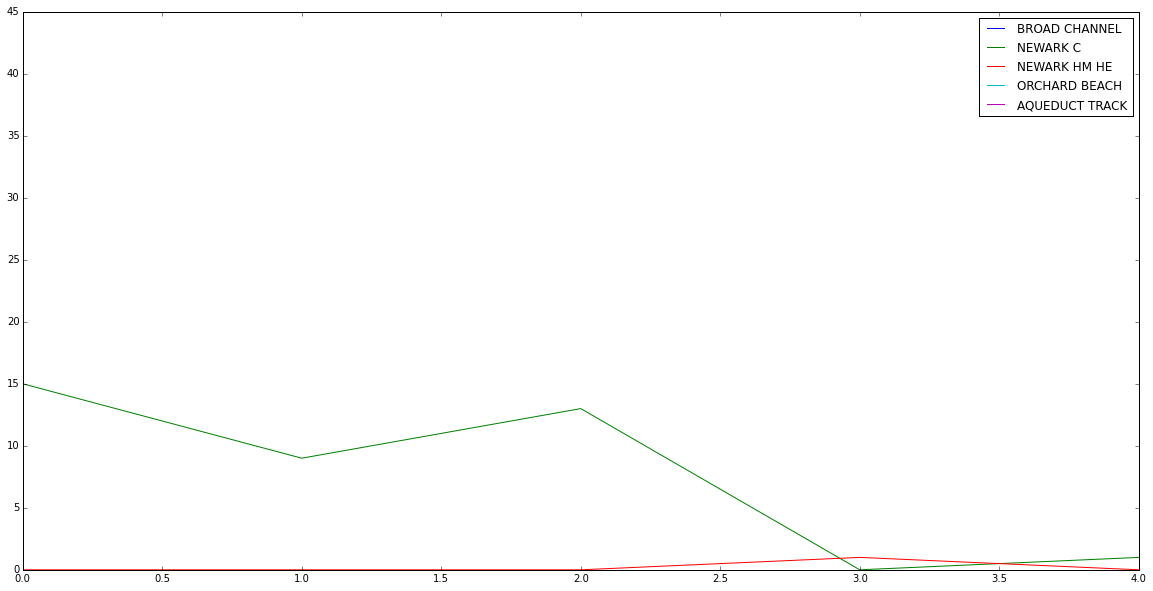

## Analysis of 4

This analysis follows all of the others, as stations that are most entered are central hubs which have many train connections. I will also add these are geographically correlated with many of the busy / happening areas in the city, which makes sense because the MTA should have built stations where people needed to go, and people would move to these areas. Its recurssive!